# **20-minute neighbourhoods: understanding housing density in Bradford**

## **Disclaimer**
This analysis was part of a larger piece of work on 20-minute neighbourhoods as part of the GEOG5403 Creative Coding for Urban Problems module on the MSc Urban Data Science & Analytics programme at the University of Leeds.

**The content of this notebook is intended for educational and general use purposes only.**

Any use of the materials should adhere to the guidelines and policies of your educational institution.

**The author does not take any responsibility for how the materials in this repository are utilised.**

## **Summary**

In a 20-minute neighbourhood, residents can walk, wheel or cycle to key services and amenities within a return 20-minute journey. The concept is not new, but interest grew as COVID-19 lockdowns highlighted the liveability of local areas. One way to identify a 20-minute neighbourhood is to draw a suitable walk-time around an area, analyse what services exist, and then “fill in the gaps”. However, this approach does not consider wants and needs of local communities and how this can differ. The Town and Country Planning Association has built a comprehensive guide arguing most 20-minute neighbourhoods will include many similar features, like schools, greenspaces, and health facilities.

This analysis looks at potential 20-minute neighbourhoods in Bradford, with the aim of understanding housing density to determine where people live and therefore which areas might have the most households benefit from investment in the 20-minute neighbourhood concept.

Using population-weighted centroids (PWCs) for each output area (OA), an 800m Euclidian buffer is drawn around this point to reflect 20-minute neighbourhoods, as shown in Figure 1. OAs are the smallest census geography, with PWCs reflecting where people live compared to the centre-point of the polygon. However, OA polygons are used to visualise results for clarity, avoiding buffer overlap.

**Figure 1: Defining neighbourhoods**

![Figure 1: Defining neighbourhoods](Images/Methodology_summary.png)

For housing, OA populations could have been used but would include everyone in any OA with a PWC inside the neighbourhood buffer, rather than the households within the neighbourhood itself. Instead, domestic EPC ratings since 2008 are used to find residential properties, spatially matching these to the buffers. Over 157,000 homes were identified, roughly 75% coverage given 210,000 households in Bradford.

Clear spatial patterns emerge of where housing is most dense, with these areas potentially being good candidates to investigate further in terms how well they are or are not setup for 20-minute living. There are limitations to this methodology, including:
* 800m Euclidian buffers not reflecting actual path networks - a network analysis may be more useful in reflecting true 20-minute neighbourhoods
* Population is not included, and so the actual number of people living in these neighbourhoods is not calculated

**Figure 2: Housing density choropleth**

![Figure 2: Housing density choropleth](Images/Housing_density_choropleth.png)

## Import and setup geographies

Links to the raw data can be found in each code cell. OA data needs to be reduced to just Bradford, and then dataframes tidied ready for use.

In [6]:
# Import required libraries
import pandas as pd
import geopandas as gpd

In [7]:
# OA polygons (BFC: Full resolution - clipped to the coastline (Mean High Water mark))
# https://geoportal.statistics.gov.uk/datasets/ons::output-areas-2021-boundaries-ew-bfc/about
OA_polygons = gpd.read_file('Data/Output_Areas_2021_Polygon/OA_2021_EW_BFC_V8.shp')

# OA Population-weighted centroids
# https://geoportal.statistics.gov.uk/datasets/ons::output-areas-december-2021-pwc-v3/about
OA_PWC = gpd.read_file('Data/Output_Areas_2021_Centroid/PopCentroids_EW_2021_V3.shp')

In [8]:
# OA to LSOA to MSOA to LAD lookup
# https://geoportal.statistics.gov.uk/datasets/output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2021-lookup-in-england-and-wales-v2-1/about
OA_lookup = pd.read_csv('Data/Output_Area_Lookup_in_England_and_Wales_v3.csv')

### Error can be ignored - it is because of Welsh spellings in a certain column.
### This is not relevant to, nor will it affect, this study as these columns/rows will not be used.

C:\Users\jessa\AppData\Local\Temp\ipykernel_22588\2029565164.py:3: DtypeWarning: Columns (3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  OA_lookup = pd.read_csv('Data/Output_Area_Lookup_in_England_and_Wales_v3.csv')


In [9]:
# Remove unnecessary columns from OA lookup, keeping only required columns in new dataframe
OA_lookup_trim = OA_lookup[['OA21CD','LAD22CD','LAD22NM']]

In [10]:
# Filter OA lookup to just Bradford
Bradford_OA_lookup = OA_lookup_trim[OA_lookup_trim['LAD22NM'] == 'Bradford']

In [11]:
# Check how many OAs are left - this number is an important reference point for further data wrangling tasks
len(Bradford_OA_lookup)

1575

In [12]:
# Merge Bradford_OA_lookup with OA polygons to reduce the geodataframe containing the polygons to only Bradford OAs
Bradford_OA_polygons = OA_polygons.merge(Bradford_OA_lookup, how='right', on='OA21CD')

In [13]:
# Check number of OAs is same as in the reduced Bradford OA lookup dataframe
print(len(Bradford_OA_polygons))
print(len(Bradford_OA_polygons) == len(Bradford_OA_lookup))

1575
True


In [14]:
# Merge Bradford_OA_lookup with OA PWCs to reduce the geodataframe containing the PWCs to only Bradford OAs
Bradford_OA_PWC = OA_PWC.merge(Bradford_OA_lookup, how='right', on='OA21CD')

In [15]:
# Check number of OAs is same as in the reduced Bradford OA lookup dataframe
print(len(Bradford_OA_PWC))
print(len(Bradford_OA_PWC) == len(Bradford_OA_lookup))

1575
True


In [16]:
# Drop unrequired columns
Bradford_OA_polygons_tidy = Bradford_OA_polygons.drop([
    'LSOA21CD','LSOA21NM','LSOA21NMW','BNG_E','BNG_N','LAT','LONG','GlobalID','LAD22CD','LAD22NM'], axis=1)
Bradford_OA_PWC_tidy = Bradford_OA_PWC.drop(['GlobalID','LAD22CD','LAD22NM'], axis=1)

# Rename geometry columns and set geometry
Bradford_OA_polygons = Bradford_OA_polygons_tidy.set_geometry('geometry').rename_geometry('Polygon')
Bradford_OA_PWC = Bradford_OA_PWC_tidy.set_geometry('geometry').rename_geometry('PWC')

## Build 20-minute neighbourhoods using 800m Euclidian buffer

As highlighted in the summary, an 800m Euclidian buffer around each PWC will be used to act as the 20-minute neighbourhoods.

In [18]:
# Import required libraries
from shapely.geometry import Point

In [19]:
# Function to create a buffer around a point with a given radius
def create_buffer(point, radius):
    return point.buffer(radius)

# Define the radius of the circle (in meters)
radius_meters = 800

# Create a new column in the GeoDataFrame to store the buffer polygons
Bradford_OA_PWC['buffer'] = Bradford_OA_PWC['PWC'].apply(lambda point: create_buffer(point, radius_meters))

# Now, 'buffer' column contains the buffer polygons around each point with a radius of 800 meters

In [20]:
# Set the 'buffer' to be the geometry
Bradford_OA_PWC.set_geometry('buffer', inplace=True)

## Get locations of residential properties

To obtain the location of the houses, EPC ratings since 2008 is combined with UPRN point data. Properties might have multiple EPC ratings, and so the data must be ordered newest to oldest, and duplicates removed keeping only the latest rating. The EPC ratings can then be merged with the UPRN data to obtain the point of each property, setting this as the geometry for further analysis.

#### EPC ratings

In [23]:
# EPC Ratings
# https://epc.opendatacommunities.org/
EPC_Ratings = pd.read_csv('Data/Housing/domestic-E08000032-Bradford/certificates.csv')

C:\Users\jessa\AppData\Local\Temp\ipykernel_22588\1129622751.py:3: DtypeWarning: Columns (15,34,37) have mixed types. Specify dtype option on import or set low_memory=False.
  EPC_Ratings = pd.read_csv('Data/Housing/domestic-E08000032-Bradford/certificates.csv')


In [24]:
# Step 1: Sort by date column in descending order
EPC_sorted = EPC_Ratings.sort_values(by='LODGEMENT_DATETIME', ascending=False)

# Step 2: Remove duplicates keeping the first instance based on 'UPRN' column
EPC_unique = EPC_sorted.drop_duplicates(subset='UPRN', keep='first')

In [25]:
# Check how properties are in the dataframe
len(EPC_unique)

157255

#### UPRNs

In [27]:
# UPRNs
# https://osdatahub.os.uk/downloads/open/OpenUPRN
UPRNs = pd.read_csv('Data/Housing/osopenuprn_202404_csv/osopenuprn_202404.csv')

In [28]:
UPRNs.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
0,1,358260.66,172796.5,51.452601,-2.602075
1,26,352967.00,181077.0,51.526633,-2.679361
2,27,352967.00,181077.0,51.526633,-2.679361
3,30,354800.00,180469.0,51.521317,-2.652862
4,31,354796.00,180460.0,51.521236,-2.652918


#### Merge the two dataframes

In [30]:
# Merge EPC Ratings and UPRNs
Matched = EPC_unique.merge(UPRNs, how='inner', on='UPRN')

In [31]:
# Keep only columns required for analysis
Matched_trim = Matched[['UPRN','LATITUDE','LONGITUDE']].copy()

In [32]:
# Convert the Latitude and Longitude columns into Point objects
geometry = [Point(xy) for xy in zip(Matched_trim['LONGITUDE'], Matched_trim['LATITUDE'])]

# Convert to a GeoDataFrame
Matched_final = gpd.GeoDataFrame(Matched_trim, geometry=geometry).set_crs('epsg:4326')

In [33]:
# Change crs to match other data
Matched_final = Matched_final.to_crs(27700)

In [34]:
Matched_final.head()

,UPRN,LATITUDE,LONGITUDE,geometry
0,1.000512e+11,53.763624,-1.768966,POINT (415327.798 429721.658)
1,1.000512e+11,53.801380,-1.826545,POINT (411521.815 433911.593)
2,1.000512e+11,53.802175,-1.829245,POINT (411343.819 433999.592)
3,1.000512e+11,53.781098,-1.816461,POINT (412191.822 431656.624)
4,1.009167e+10,53.823379,-1.860954,POINT (409250.808 436354.194)


In [35]:
len(Matched_final)

157252

In [36]:
# Check length of the final dataframe is the same as the unique properties that were found
len(Matched_final) == len(EPC_unique)

False

In [37]:
# Check the difference to see how many properties in the EPC ratings did NOT match a UPRN (this could be because they were missing or entered incorrectly)
len(Matched_final) - len(EPC_unique)

-3

## Mapping properties

A quick map illustrates where the properties are located.

In [39]:
# Import required libraries
import contextily as cx
import matplotlib.pyplot as plt

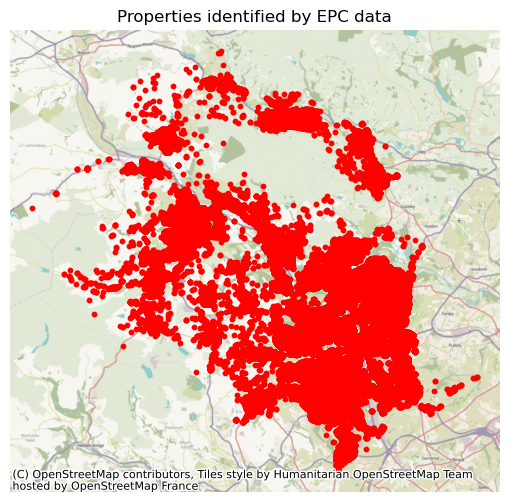

In [40]:
# Plotting the GeoDataFrame with basemap
ax = Matched_final.plot(figsize=(10, 6), markersize=10, color='red')

# Add basemap using contextily
cx.add_basemap(ax, zoom=12, crs=Matched_final.crs.to_string())

# Set title
plt.title('Properties identified by EPC data')

# Turn off the axes
ax.axis('off')

plt.show()

## Spatially match properties to neighbourhood buffers

Next the properties can be spatially matched to the neighbourhood buffers to determine how many properties are in each neighbourhood. It is important to reiterate that this EPC rating methodology has roughly 75% coverage of all households, and does not include actual population counts which could vary depending on size of property.

In [42]:
# Make a copy of the dataframe containing the buffers with only the required columns
Bradford_PWC_buffers = Bradford_OA_PWC[['OA21CD','buffer']].copy()

In [43]:
# Spatially match the properties to the buffers
joined = Bradford_PWC_buffers.sjoin(Matched_final, how="left", predicate="intersects")

In [44]:
# Visual check of the dataframe - there are duplicated rows due to the overlap of some neighbourhood buffer zones
joined

,OA21CD,buffer,index_right,UPRN,LATITUDE,LONGITUDE
0,E00053353,"POLYGON ((414438.052 439495.615, 414434.200 43...",35797,1.000519e+11,53.847941,-1.784022
0,E00053353,"POLYGON ((414438.052 439495.615, 414434.200 43...",63910,2.000047e+11,53.848048,-1.783626
0,E00053353,"POLYGON ((414438.052 439495.615, 414434.200 43...",58772,1.000513e+11,53.845011,-1.789341
0,E00053353,"POLYGON ((414438.052 439495.615, 414434.200 43...",11651,1.000513e+11,53.845155,-1.789355
0,E00053353,"POLYGON ((414438.052 439495.615, 414434.200 43...",157213,1.000513e+11,53.845362,-1.789309
...,...,...,...,...,...,...
1574,E00177810,"POLYGON ((410759.264 435503.188, 410755.412 43...",119131,1.009098e+10,53.821992,-1.855611
1574,E00177810,"POLYGON ((410759.264 435503.188, 410755.412 43...",50374,1.000519e+11,53.816365,-1.848081
1574,E00177810,"POLYGON ((410759.264 435503.188, 410755.412 43...",31264,1.000519e+11,53.816429,-1.848704
1574,E00177810,"POLYGON ((410759.264 435503.188, 410755.412 43...",100903,1.000519e+11,53.816465,-1.848628


In [45]:
# Group by OA21CD and count the unique UPRNs
agg_df = joined.groupby('OA21CD')['UPRN'].nunique().reset_index()

# Rename the column to indicate the count of UPRNs
agg_df.rename(columns={'UPRN': 'UPRN_Count'}, inplace=True)

In [46]:
# Visual check
agg_df

,OA21CD,UPRN_Count
0,E00053353,214
1,E00053354,1148
2,E00053355,1405
3,E00053356,965
4,E00053357,1441
...,...,...
1570,E00177867,3780
1571,E00177868,2910
1572,E00177869,5265
1573,E00177870,2096


## Add OA polygons back in and map choropleth

The results are easier to visualise using the OA polygons to remove any buffer overlap. Results show clear areas of higher density neighbourhoods, particuarly around large town in the district and the city centre.

In [48]:
# Merge dataframes to add polygons back in
for_choropleth = pd.merge(Bradford_OA_polygons, agg_df, on='OA21CD', how='inner')

In [49]:
# Visual check
for_choropleth

,OA21CD,Polygon,UPRN_Count
0,E00053353,"POLYGON ((415817.093 440872.597, 415821.094 44...",214
1,E00053354,"POLYGON ((415078.000 439967.001, 415058.323 43...",1148
2,E00053355,"POLYGON ((416252.367 439816.041, 416253.270 43...",1405
3,E00053356,"POLYGON ((416668.000 439392.028, 416667.653 43...",965
4,E00053357,"POLYGON ((415143.909 439176.235, 415143.000 43...",1441
...,...,...,...
1570,E00177806,"POLYGON ((404057.041 446035.505, 404056.753 44...",2069
1571,E00177807,"POLYGON ((418884.032 438045.945, 418866.019 43...",1790
1572,E00177808,"POLYGON ((414782.332 437464.729, 414782.519 43...",3114
1573,E00177809,"POLYGON ((402252.845 444586.747, 402253.000 44...",434


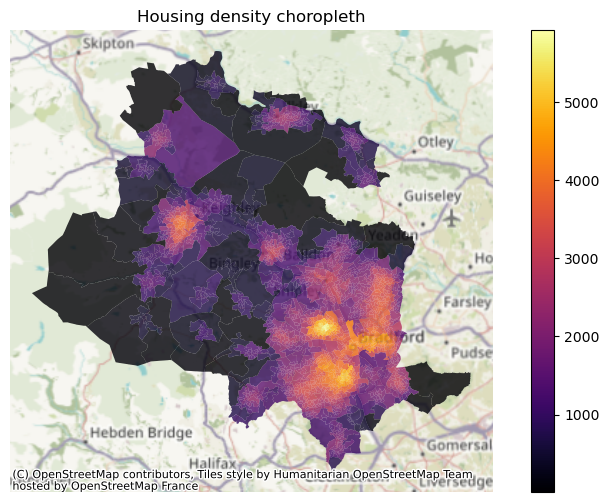

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the choropleth map
for_choropleth.plot(column='UPRN_Count', cmap='inferno', legend=True, ax=ax, alpha=0.8)

# Add basemap using contextily
cx.add_basemap(ax, crs=for_choropleth.crs.to_string(), zoom=10)  # Set the coordinate reference system (CRS)

# Set title
plt.title('Housing density choropleth')

# Turn off the axes
ax.axis('off')

# Show the plot
plt.show()

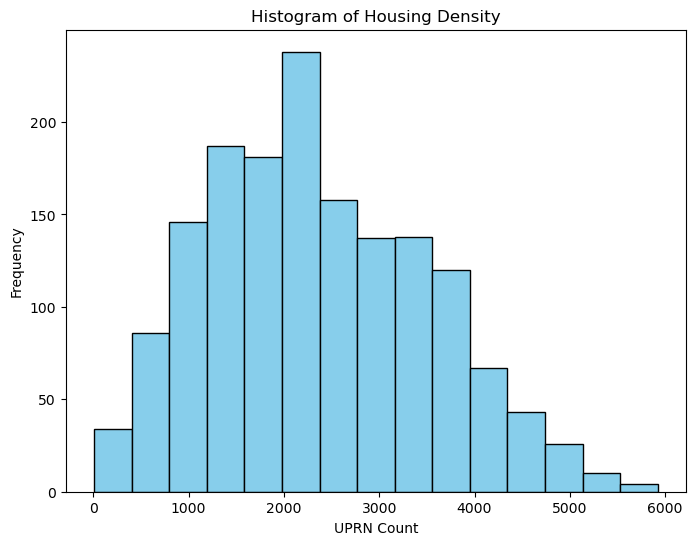

In [51]:
plt.figure(figsize=(8, 6))

# Create histogram
plt.hist(for_choropleth['UPRN_Count'], bins=15, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('UPRN Count')
plt.ylabel('Frequency')
plt.title('Histogram of Housing Density')

# Show the plot
plt.show()
